下载数据集MNIST

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST


def get_mnist(data_path: str = './data'):
    tr = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    trainset = MNIST(data_path, train=True, download=True, transform=tr)
    testset = MNIST(data_path, train=False, download=True, transform=tr)

    return trainset, testset


trainset, testset = get_mnist()

In [2]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

可视化一些图像

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt


def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    idx = list(range(len(trainset_.data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    num_cols = 8
    num_rows = int(np.ceil(len(idx)/num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows*2),
                            nrows=num_rows, ncols=num_cols)

    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_.data[i], cmap='gray')

will display images with idx: [56549, 39643, 54874, 13358, 34459, 46787, 53745, 15734, 5132, 42337, 17404, 9227, 37728, 41546, 45876, 47904, 52324, 38573, 10199, 42709, 52761, 25865, 20478, 20474, 28344, 4268, 54031, 5104, 21154, 26217, 38414, 53846]


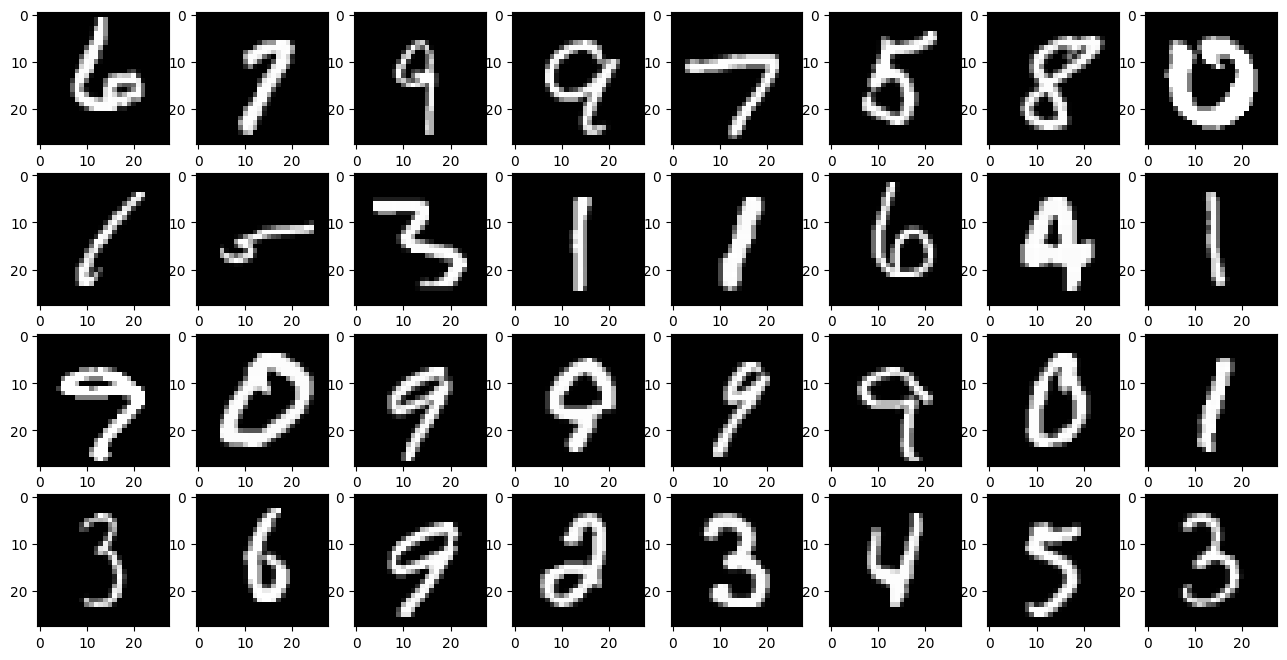

In [4]:
visualise_n_random_examples(trainset, n=32)

CNN架构

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


In [7]:
def train(net, trainloader, optimizer, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
    return net


def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(epochs: int, lr: float, momentum: float = 0.9):

    model = Net(num_classes=10)

    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    trainset, testset = get_mnist()
    trainloader = DataLoader(trainset, batch_size=64,
                             shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=128)

    trained_model = train(model, trainloader, optim, epochs)

    loss, accuracy = test(trained_model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

In [8]:
run_centralised(epochs=5, lr=0.01)

loss = 3.1100239573825093
accuracy = 0.9864


联邦学习

In [9]:
# 将数据集随机划分成100个等大小的部分
def split_data(dataset, num_nodes):
    num_items = len(dataset) // num_nodes
    splits = []
    for i in range(num_nodes):
        splits.append(torch.utils.data.Subset(
            dataset, range(i*num_items, (i+1)*num_items)))
    return splits


# 划分100个
splits = split_data(trainset, num_nodes=100)
print(len(splits), len(splits[0]))  # 100个数据集，每个数据集600个数据

100 600


In [10]:
# 每个数据集训练一个CNN
def train_node_on_dataset(node_id, dataset, epochs, lr, momentum):
    model = Net(num_classes=10)
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    trainloader = DataLoader(dataset, batch_size=64,
                             shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=128)
    trained_model = train(model, trainloader, optim, epochs)
    loss, accuracy = test(trained_model, testloader)
    return trained_model, accuracy

In [11]:
testloader = DataLoader(testset, batch_size=128)
# 计算每个节点得到的模型的平均值


def average_models(models):
    model = Net(num_classes=10)
    state_dicts = [m.state_dict() for m in models]
    avg_state = {}
    for k in model.state_dict().keys():
        avg_state[k] = torch.stack([sd[k] for sd in state_dicts]).mean(0)
    model.load_state_dict(avg_state)
    return model
# 查看平均模型在测试集上的表现


def test_averaged_model(models):
    avg_model = average_models(models)
    loss, accuracy = test(avg_model, testloader)
    return accuracy

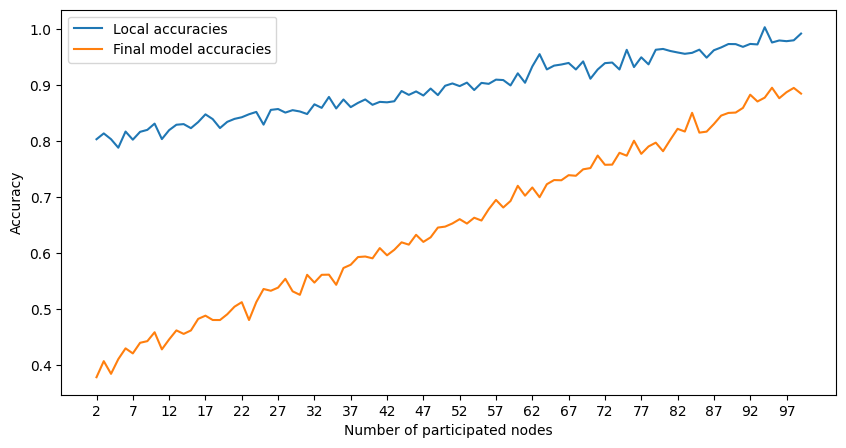

In [15]:
participated_nodes = 2
upper_limit = 99
local_avg_accuracies = []
final_model_accuracies = []
while participated_nodes <= upper_limit:
    local_models = []
    # 将splits随机打乱
    random.shuffle(splits)
    tmp_result = 0
    for i, split in enumerate(splits):
        if i == participated_nodes:
            break
        result = train_node_on_dataset(
            i, split, epochs=10, lr=0.01, momentum=0.9)
        local_models.append(result[0])
        tmp_result += result[1]
    local_avg_accuracies.append(tmp_result/participated_nodes)
    # 开始测试
    final_model_accuracies.append(test_averaged_model(local_models))
    participated_nodes += 1

plt.figure(figsize=(10, 5))
plt.plot(local_avg_accuracies, label='Local accuracies')
plt.plot(final_model_accuracies, label='Final model accuracies')
plt.xlabel('Number of participated nodes')

# x是从2到98的，每五个显示一个
plt.xticks(range(0, 98, 5), range(2, 99, 5))
plt.ylabel('Accuracy')
plt.legend()
plt.show()